# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [130]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import plotly.express as px #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

Итак, прочитаем нашу таблицу:

In [131]:
churn_data = pd.read_csv('churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

In [132]:
churn_data.drop(columns = 'RowNumber', inplace = True)

Посмотрим на соотношение ушедших и лояльных клиентов

In [133]:
exit_counts = churn_data['Exited'].value_counts()
exit_counts_df = exit_counts.to_frame()
exit_counts_df = exit_counts_df.rename(index={1: 'Churn', 0: 'Loyal'})

exit_counts_df['percent'] = round(((exit_counts_df['count']/exit_counts_df['count'].sum()) * 100), 2)
exit_counts_df['percent'] = exit_counts_df['percent'].astype(str) + '%'

fig1 = px.bar(
    data_frame=exit_counts_df,
    labels = {'Exited': 'Статус клиента', 'value':'Количество клиентов'},
    text ='percent',
    color=['blue', 'orange'],
    title='Cоотношение ушедших и лояльных клиентов' 
)
                                

fig1.show();

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



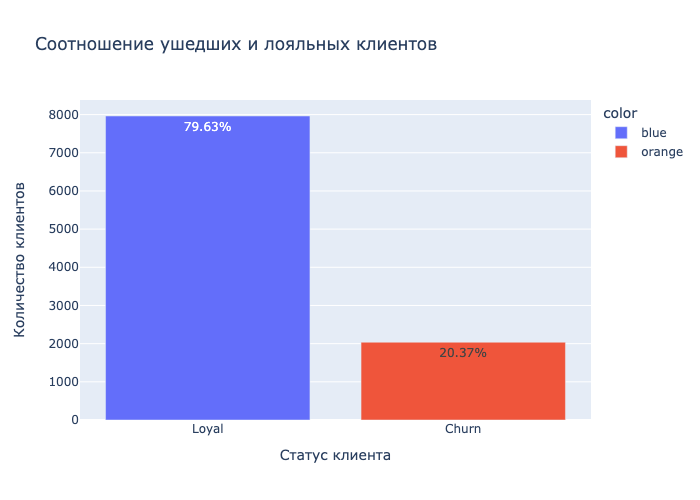

In [134]:
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import Image

pio.write_image(fig1, "Fig1.png")

Image(filename='Fig1.png')

Распределение не равномерное, знчатит для оценки качества модели логистической регрессии будем использовать метрику F-1 мера. 

Построим графики, показывающие взаимосвязь между исходными (числовыми) признаками и целевым признаком.

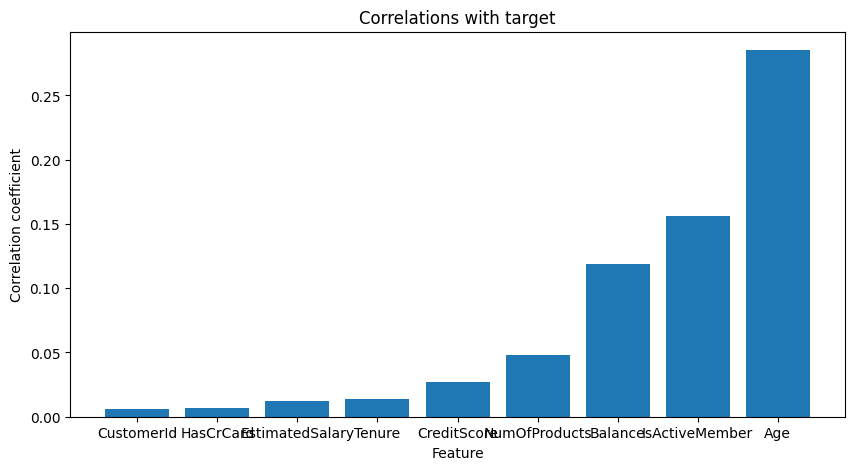

In [135]:
#Вычисляем модуль корреляции
corr_with_target = churn_data.corr(numeric_only=True)['Exited'].abs().sort_values()
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('Exited')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

Признаки 'Age', 'IsActiveMember' и 'Balance' имеют самую высокую корреляцию с целевым признаком.

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [136]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 13)

Сразу избавимся от заведомо неинформативных признаков: страна, идентификатор пользователя и имя клиента, от признака обозначающего номер строки мы уже избавились ранее.

In [137]:
churn_data = churn_data.drop(['Geography', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [138]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [139]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [140]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,Female,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,Male,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,Male,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,Male,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,Female,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


In [141]:
churn_data['NumOfProducts'].value_counts()

NumOfProducts
1    1349
2    1040
3      96
4      24
Name: count, dtype: int64

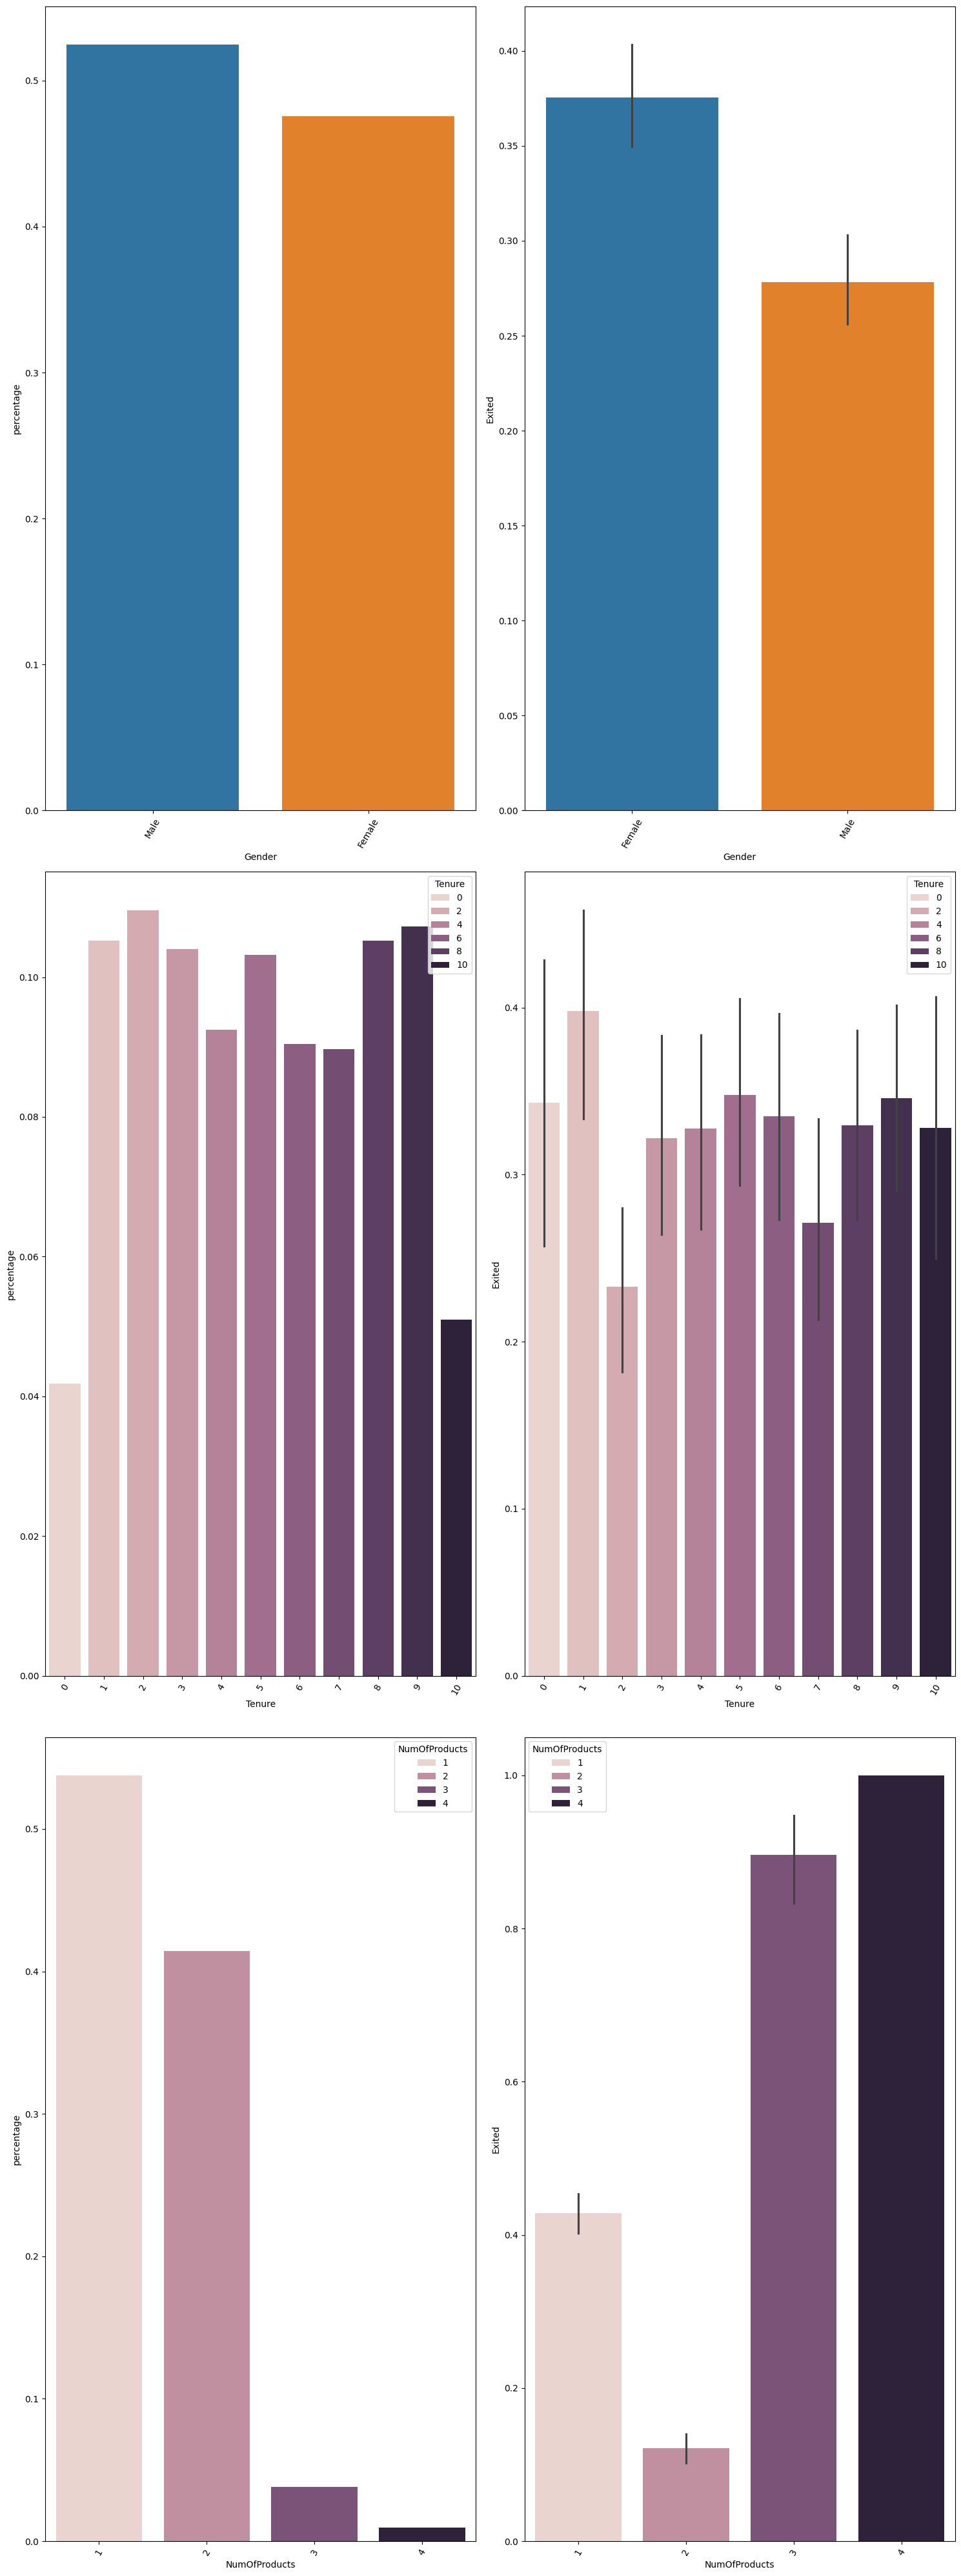

In [142]:

cat_features = ['Gender', 'Tenure', 'NumOfProducts']
cat_features

n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_data = (churn_data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x=feature, y='percentage', hue=feature, ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей со статусом Exited в зависимости от категории Tenure
    mean_barplot = sns.barplot(data=churn_data, x=feature, y='Exited', hue=feature, ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

Признаки gender и numofproducts имеют по две и четыре уникальных категории соответственно — с ними мы воспользуемся горачим кодированием, как есть. Признак tenure тоже можно отнести к категориальным признакам, поэтому мы хакодируем его, предварительно объединив некоторые категории в группы, чтобы уменьшить их число. Так, на графике видно, что людей с уровнем tenure 1 можно выделить в отдельную группу по уровню churn (самый выскокой показатель), а также людей с уровнем tenure 2 и 7 (самые маленькие показатели), а всех остальных — в отдельную группу. Таким образом мы вуделим 3 группы, к которым можно применить горячее кодирование. Назовем их "high", "low" и "mid" соответственно.

In [143]:
tenure_data = churn_data.copy()
#Определяем уровни tenure в отдельную категорию. 
tenure_data['Tenure'] = tenure_data['Tenure'].apply(
    lambda x: 'High' if x == 2 or x == 7 else x)
tenure_data['Tenure'] = tenure_data['Tenure'].apply(
    lambda x: 'Low' if x == 1 else x)
tenure_data['Tenure'] = tenure_data['Tenure'].apply(
    lambda x: 'Mid' if x == 0 or x == 3 or x == 4 or x == 5 or x == 6 or x == 8 or x == 9 or x ==10 else x)

tenure_data['Tenure'].unique()


array(['Mid', 'Low', 'High'], dtype=object)

Теперь применим горячее кодирование к категориальным признакам.

In [144]:
encoded_data = pd.get_dummies(tenure_data, columns = ['Tenure', 'Gender', 'NumOfProducts'], dtype=int)
encoded_data.head()

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Tenure_High,Tenure_Low,Tenure_Mid,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
7,376,29,115046.74,1,0,119346.88,1,0.963969,0.137931,12.965517,0,0,1,1,0,0,0,0,1
15,616,45,143129.41,0,1,64327.26,0,2.225020,0.066667,13.688889,0,0,1,0,1,0,1,0,0
16,653,58,132602.88,1,0,5097.67,1,26.012449,0.017241,11.258621,0,1,0,0,1,1,0,0,0
26,756,36,136815.64,1,1,170041.95,0,0.804599,0.055556,21.000000,1,0,0,0,1,1,0,0,0
28,574,43,141349.43,1,1,100187.43,0,1.410850,0.069767,13.348837,0,0,1,1,0,1,0,0,0


Посмотрим на распределение числовых признаков, чтобы при необходимости логарифмировать их.

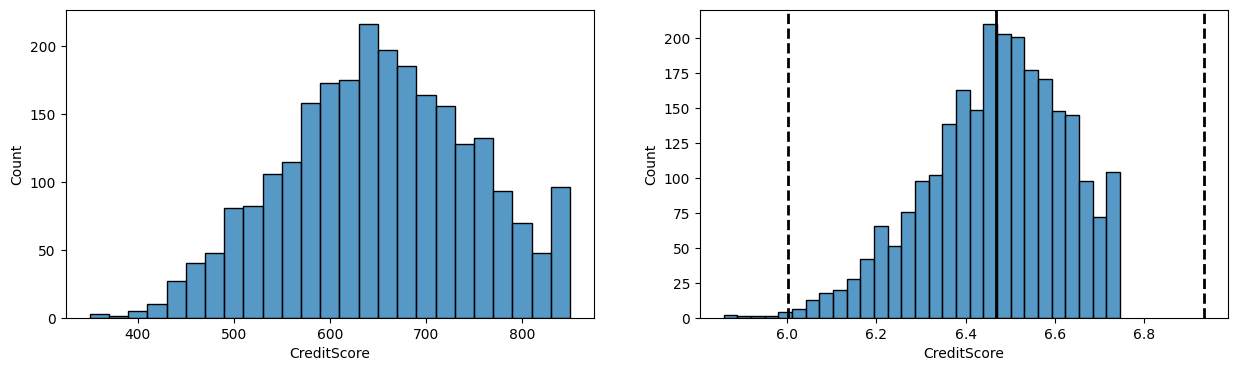

In [145]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #figure + plot
#Creating a histogram
sns.histplot(data=encoded_data, x='CreditScore', ax=axes[0]);
log_credit_score = np.log(encoded_data['CreditScore'])
#histogram for ligarithmic data
sns.histplot(data=log_credit_score, ax=axes[1]);
#Adding the lines for the mean and three strandart deviation lines
axes[1].axvline(log_credit_score.mean(), color='k', lw=2)
axes[1].axvline(log_credit_score.mean()+ 3 *log_credit_score.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_credit_score.mean()- 3 *log_credit_score.std(),
                color='k', ls='--', lw=2);

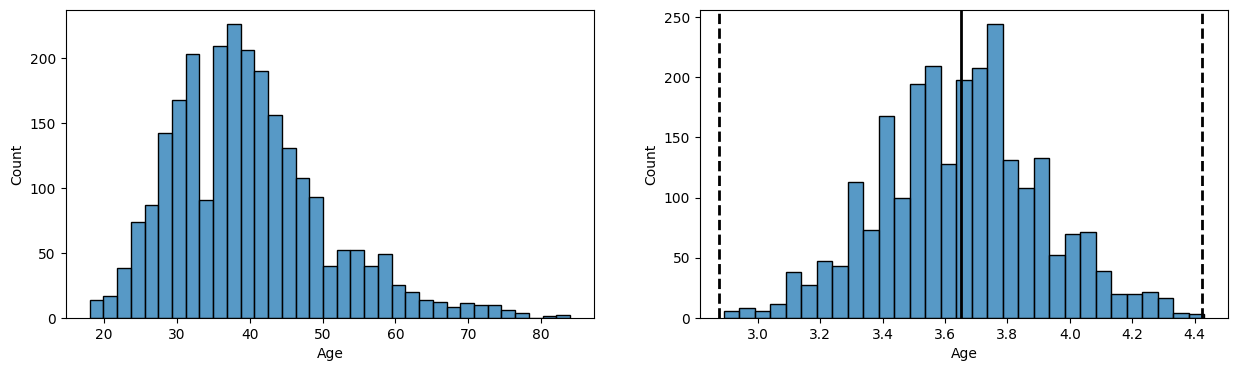

In [146]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #figure + plot
#Creating a histogram
sns.histplot(data=encoded_data, x='Age', ax=axes[0]);
log_age = np.log(encoded_data['Age'])
#histogram for ligarithmic data
sns.histplot(data=log_age, ax=axes[1]);
#Adding the lines for the mean and three strandart deviation lines
axes[1].axvline(log_age.mean(), color='k', lw=2)
axes[1].axvline(log_age.mean()+ 3 *log_age.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_age.mean()- 3 *log_age.std(),
                color='k', ls='--', lw=2);

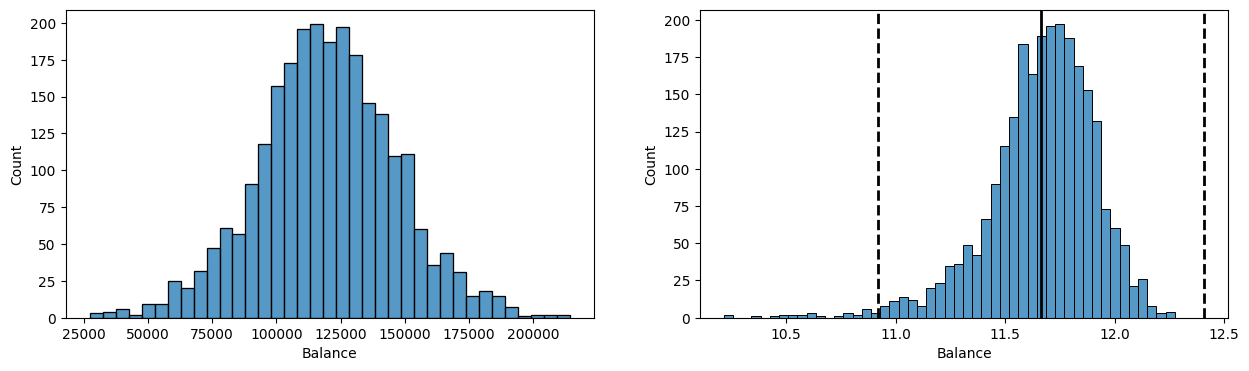

In [147]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #figure + plot
#Creating a histogram
sns.histplot(data=encoded_data, x='Balance', ax=axes[0]);
log_balance = np.log(encoded_data['Balance'])
#histogram for ligarithmic data
sns.histplot(data=log_balance, ax=axes[1]);
#Adding the lines for the mean and three strandart deviation lines
axes[1].axvline(log_balance.mean(), color='k', lw=2)
axes[1].axvline(log_balance.mean()+ 3 *log_balance.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_balance.mean()- 3 *log_balance.std(),
                color='k', ls='--', lw=2);

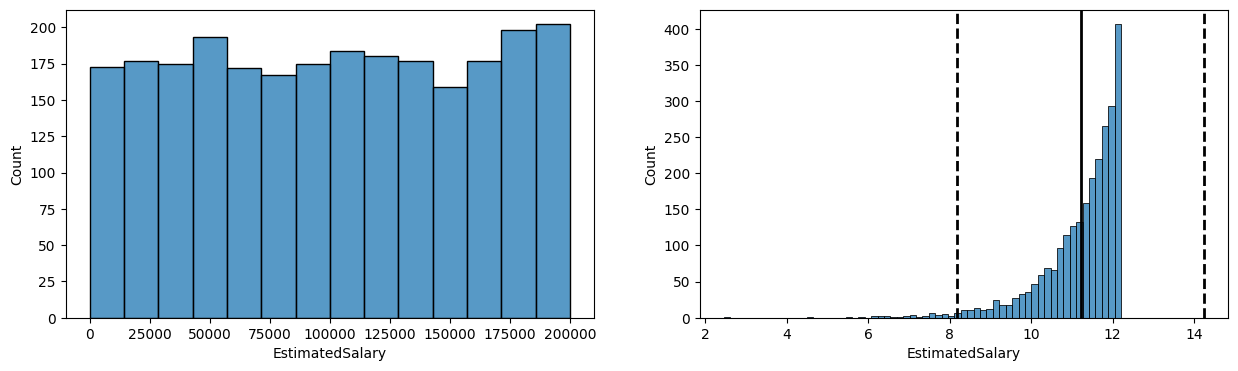

In [148]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #figure + plot
#Creating a histogram
sns.histplot(data=encoded_data, x='EstimatedSalary', ax=axes[0]);
log_est_salary = np.log(encoded_data['EstimatedSalary'])
#histogram for ligarithmic data
sns.histplot(data=log_est_salary, ax=axes[1]);
#Adding the lines for the mean and three strandart deviation lines
axes[1].axvline(log_est_salary.mean(), color='k', lw=2)
axes[1].axvline(log_est_salary.mean()+ 3 *log_est_salary.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_est_salary.mean()- 3 *log_est_salary.std(),
                color='k', ls='--', lw=2);

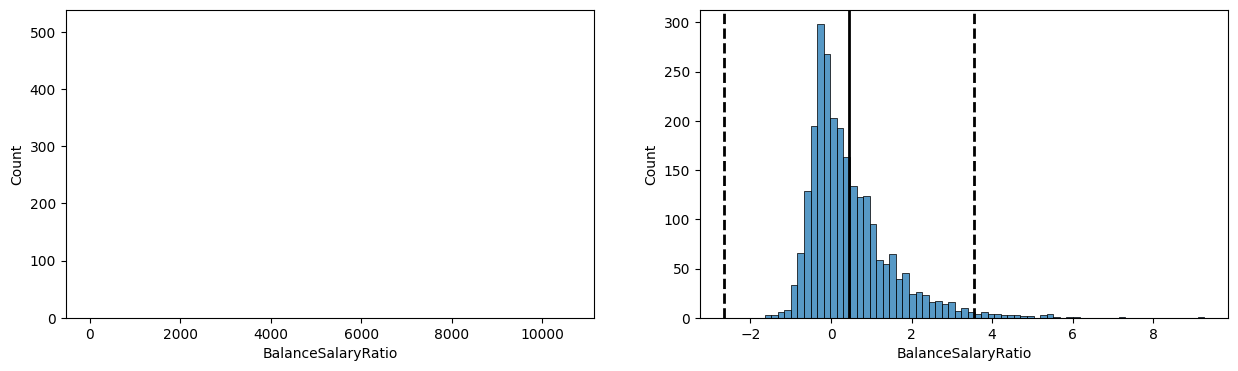

In [149]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #figure + plot
#Creating a histogram
sns.histplot(data=encoded_data, x='BalanceSalaryRatio', ax=axes[0]);
log_b_s_ratio = np.log(encoded_data['BalanceSalaryRatio'])
#histogram for ligarithmic data
sns.histplot(data=log_b_s_ratio, ax=axes[1]);
#Adding the lines for the mean and three strandart deviation lines
axes[1].axvline(log_b_s_ratio.mean(), color='k', lw=2)
axes[1].axvline(log_b_s_ratio.mean()+ 3 *log_b_s_ratio.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_b_s_ratio.mean()- 3 *log_b_s_ratio.std(),
                color='k', ls='--', lw=2);

?? Почему гистограмма не строится для этого признака ??

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract



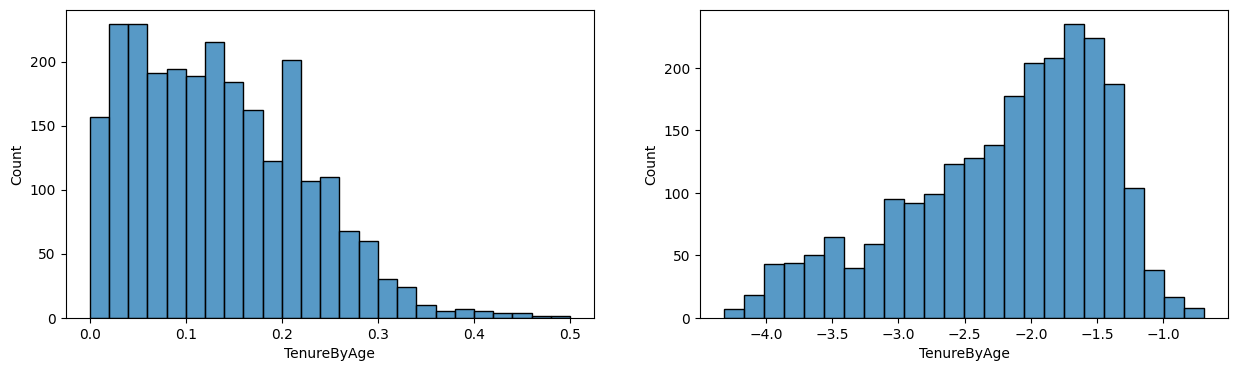

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #figure + plot
#Creating a histogram
sns.histplot(data=encoded_data, x='TenureByAge', ax=axes[0]);
log_t_by_age = np.log(encoded_data['TenureByAge'])
#histogram for ligarithmic data
sns.histplot(data=log_t_by_age, ax=axes[1]);
#Adding the lines for the mean and three strandart deviation lines
axes[1].axvline(log_t_by_age.mean(), color='k', lw=2)
axes[1].axvline(log_t_by_age.mean()+ 3 *log_t_by_age.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_t_by_age.mean()- 3 *log_t_by_age.std(),
                color='k', ls='--', lw=2);

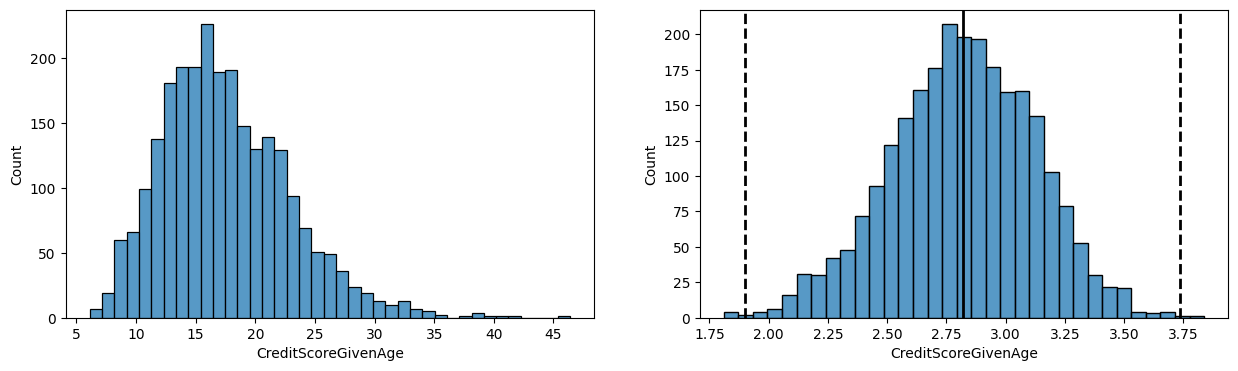

In [151]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #figure + plot
#Creating a histogram
sns.histplot(data=encoded_data, x='CreditScoreGivenAge', ax=axes[0]);
log_cr_score_age = np.log(encoded_data['CreditScoreGivenAge'])
#histogram for ligarithmic data
sns.histplot(data=log_cr_score_age, ax=axes[1]);
#Adding the lines for the mean and three strandart deviation lines
axes[1].axvline(log_cr_score_age.mean(), color='k', lw=2)
axes[1].axvline(log_cr_score_age.mean()+ 3 *log_cr_score_age.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_cr_score_age.mean()- 3 *log_cr_score_age.std(),
                color='k', ls='--', lw=2);

In [152]:
#Создадим копию таблицы с логарифмированными числовыми признаками
features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'BalanceSalaryRatio', 'CreditScoreGivenAge']
#Признак TenureByAge логарифмируем отдельно с добавлением эпсилона, 
#т.к. при логарифмировании для графика мы получили ошибку: "divide by zero encountered in log" и "invalid value encountered in subtract"
log_data = encoded_data.copy()

epsilon = 1e-9
log_data['TenureByAge'] = log_data['TenureByAge'] + epsilon
log_data['TenureByAge'] = np.log(log_data['TenureByAge'])

for i, feature in enumerate(features):
    log_data[feature]= np.log(encoded_data[feature])
    
log_data.head()

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Tenure_High,Tenure_Low,Tenure_Mid,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
7,5.929589,3.367296,11.653094,1,0,11.689789,1,-0.036696,-1.981001,2.562293,0,0,1,1,0,0,0,0,1
15,6.423247,3.806662,11.871504,0,1,11.071739,0,0.799766,-2.708050,2.616584,0,0,1,0,1,0,1,0,0
16,6.481577,4.060443,11.795114,1,0,8.536539,1,3.258575,-4.060443,2.421134,0,1,0,0,1,1,0,0,0
26,6.628041,3.583519,11.826390,1,1,12.043800,0,-0.217411,-2.890372,3.044522,1,0,0,0,1,1,0,0,0
28,6.352629,3.761200,11.858990,1,1,11.514798,0,0.344192,-2.662588,2.591429,0,0,1,1,0,1,0,0,0


Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

<Axes: >

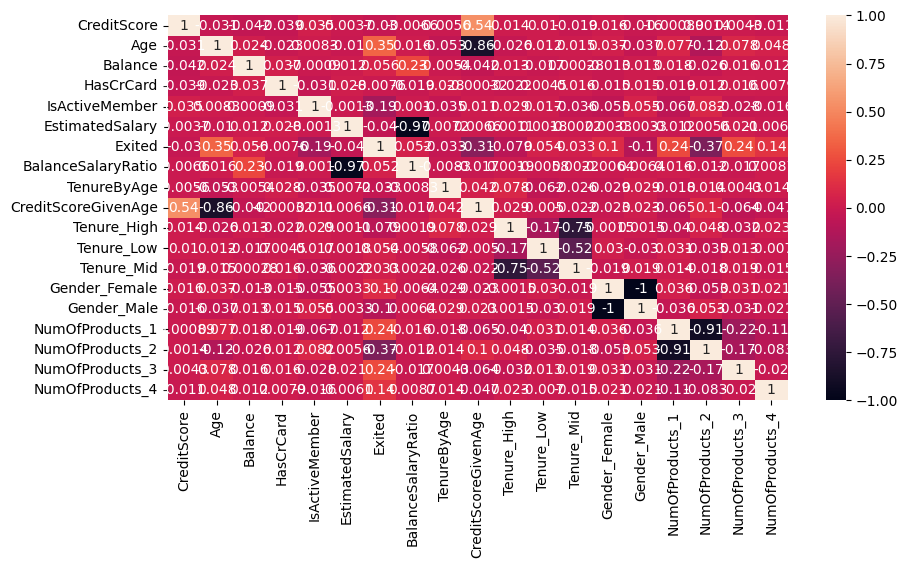

In [153]:
plt.figure(figsize = (10, 5))
sns.heatmap(log_data.corr(), annot = True)

Признаки CreditScoreGivenAge и Age, BalanceSalaryRatio и EstimatedSalary,  NumOfProducts_1 и NumOfProducts2 обладают мультиколлинераностью. Удалим по одному признаку из каждой пары. 

In [154]:
log_data_cleaned = log_data.drop(columns=['Age', 'EstimatedSalary', 'NumOfProducts_1'])

In [155]:
print(log_data_cleaned.shape)

(2509, 16)


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [156]:
X = log_data_cleaned.drop("Exited", axis=1)
y = log_data_cleaned["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [157]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [158]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 15)
Test shape: (628, 15)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [159]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [160]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

Будем улучшать метрику F-1 меры, т.к. она демонстирует баланс между метриками precision и recall, которые демонстрируют наличие/отсутствие у модели ложноположительных и ложноотрицательных результатов соответственно.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [161]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=1, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1271
           1       0.70      0.57      0.63       610

    accuracy                           0.78      1881
   macro avg       0.75      0.72      0.73      1881
weighted avg       0.77      0.78      0.77      1881

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       424
           1       0.69      0.54      0.61       204

    accuracy                           0.77       628
   macro avg       0.75      0.71      0.73       628
weighted avg       0.77      0.77      0.77       628



Значения целевой метрики F1 на тренировочной и тестовой выборках примерно одинаково и превышает 0.5, значит модель не демонстирует ни переобучения, ни недообучения. Все же значение 0.61-0.63 — очень низкое. Попробуем повысить его, изменив следующие параметры модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

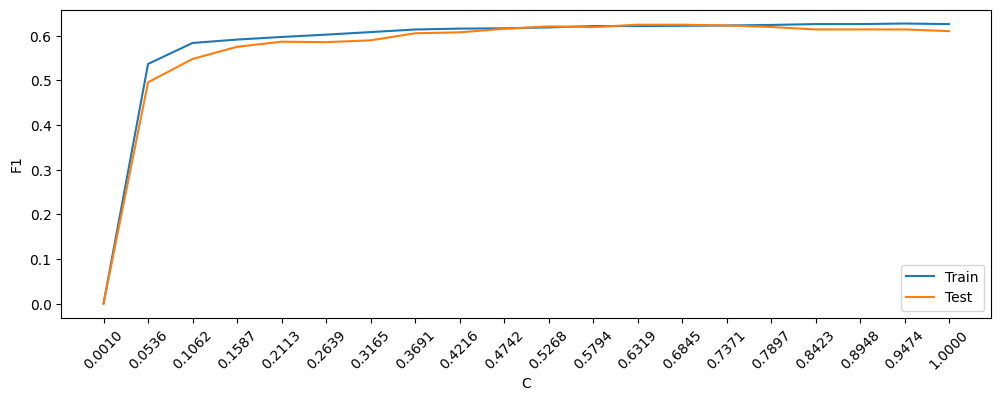

In [162]:
#Создаём список из 20 возможных значений от 0.001 до 1
c_list = np.linspace(0.001, 1, 20)
#Создаём пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []

for c in c_list:
    #Создаём объект класса линейной регрессии с L1-регуляризацией
    log_reg_c = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=1, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    C=c
)
    
    log_reg_c.fit(X_train_scaled, y_train)
    #Обучаем модель
    #Делаем предсказание для тренировочной выборки
    y_train_predict_log_reg_c = log_reg_c.predict(X_train_scaled)
    train_scores.append(metrics.f1_score(y_train, y_train_predict_log_reg_c))
    #Делаем предсказание для тестовой выборки
    y_test_predict_log_reg_c = log_reg_c.predict(X_test_scaled)
    #Рассчитываем коэффициенты детерминации для двух выборок и добавляем их в списки
    test_scores.append(metrics.f1_score(y_test, y_test_predict_log_reg_c))


#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(c_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(c_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('C') #название оси абсцисс
ax.set_ylabel('F1') #название оси ординат
ax.set_xticks(c_list) #метки по оси абсцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды


In [163]:
# Найдем точки, где F1-метрики пересекаются (находятся близко друг к другу)
tolerance = 1e-2  # Добавлаем толерантность, чтобы находить точки, которые приблизительно одинаковы.
intersection_points = []

for i in range(len(c_list)):
    if abs(train_scores[i] - test_scores[i]) < tolerance:
        intersection_points.append((c_list[i], train_scores[i], test_scores[i]))

# Находум точку пересечения с наивысшим F1
if intersection_points:
    best_point = max(intersection_points, key=lambda x: x[1])
    best_c = best_point[0]
    highest_f1 = best_point[1]
else:
    best_c = None
    highest_f1 = None

print(f"Точки пересечения метрик: {[round(point[0], 2) for point in intersection_points]}")
print(f"Самый высокий показатель F1 среди точек пересечения: {round(highest_f1, 2)}")
print(f"Значение C в самой высокой точке пересечения: {round(best_c, 2)}")



Точки пересечения метрик: [0.0, 0.37, 0.42, 0.47, 0.53, 0.58, 0.63, 0.68, 0.74, 0.79]
Самый высокий показатель F1 среди точек пересечения: 0.62
Значение C в самой высокой точке пересечения: 0.79


Попробуем построить модель с коеффициентом С = 0.79

In [164]:
#Создаем объект класса логистическая регрессия
log_reg_c = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=1, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    C=0.79
)
#Обучаем модель, минимизируя logloss
log_reg_c.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg_c.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg_c.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1271
           1       0.70      0.56      0.62       610

    accuracy                           0.78      1881
   macro avg       0.75      0.72      0.73      1881
weighted avg       0.77      0.78      0.77      1881

              precision    recall  f1-score   support

           0       0.81      0.89      0.84       424
           1       0.70      0.55      0.62       204

    accuracy                           0.78       628
   macro avg       0.75      0.72      0.73       628
weighted avg       0.77      0.78      0.77       628



Показатели F-1 на тренировочной и тестовой выборках сравнялись, показатель на тестовой выборке вырос на 0.01%. 
Попробуем теперь поменять параметр 'solver' и выберем регуляризацию l1 (по умолчанию было L2).

In [165]:
#Создаем объект класса логистическая регрессия
log_reg_c_l1 = linear_model.LogisticRegression(
    solver='saga', #алгоритм оптимизации
    random_state=1, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    C=0.79, #коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1)
    penalty='l1'
    
)
#Обучаем модель, минимизируя logloss
log_reg_c_l1.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg_c_l1.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg_c_l1.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85      1271
           1       0.70      0.58      0.63       610

    accuracy                           0.78      1881
   macro avg       0.76      0.73      0.74      1881
weighted avg       0.78      0.78      0.78      1881

              precision    recall  f1-score   support

           0       0.80      0.87      0.84       424
           1       0.68      0.56      0.61       204

    accuracy                           0.77       628
   macro avg       0.74      0.72      0.73       628
weighted avg       0.76      0.77      0.76       628



Показатели F-1 на двух выборках снова незначительно разошлись. Попробуем теперь регуляризатор elasticnet.

In [166]:
log_reg_c_elastic = linear_model.LogisticRegression(
solver='saga', #алгоритм оптимизации
random_state=1, #генератор случайных чисел
max_iter=1000, #количество итераций на сходимость
penalty='elasticnet',
l1_ratio=0.5,
C=0.47
)
    
#Обучаем модель, минимизируя logloss
log_reg_c_elastic.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg_c_elastic.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg_c_elastic.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1271
           1       0.70      0.57      0.63       610

    accuracy                           0.78      1881
   macro avg       0.75      0.72      0.74      1881
weighted avg       0.77      0.78      0.77      1881

              precision    recall  f1-score   support

           0       0.81      0.89      0.84       424
           1       0.70      0.55      0.62       204

    accuracy                           0.78       628
   macro avg       0.75      0.72      0.73       628
weighted avg       0.77      0.78      0.77       628



Показатели снова незначительно расходятся. Наилучшими гиперпараметрами для данной выборки и модели логистической регрессии являются солвер 'sag', регуляризация 'l2', и показатель коэффициента С '0.79'.

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [167]:
#Создаём генератор полиномиальных признаков в третьей степени
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test_scaled)
#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)

(1881, 815)
(628, 815)


In [168]:
#Создаем объект класса логистическая регрессия
log_reg_poly = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=1, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg_poly.fit(X_train_poly, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg_poly.predict(X_train_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg_poly.predict(X_test_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1271
           1       0.74      0.61      0.67       610

    accuracy                           0.80      1881
   macro avg       0.78      0.75      0.76      1881
weighted avg       0.80      0.80      0.80      1881

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       424
           1       0.71      0.57      0.64       204

    accuracy                           0.79       628
   macro avg       0.76      0.73      0.74       628
weighted avg       0.78      0.79      0.78       628



In [169]:
#Создаем объект класса логистическая регрессия
log_reg_poly = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=1, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    C=0.4
)
#Обучаем модель, минимизируя logloss
log_reg_poly.fit(X_train_poly, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg_poly.predict(X_train_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg_poly.predict(X_test_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1271
           1       0.73      0.60      0.66       610

    accuracy                           0.80      1881
   macro avg       0.78      0.75      0.76      1881
weighted avg       0.79      0.80      0.79      1881

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       424
           1       0.72      0.59      0.65       204

    accuracy                           0.79       628
   macro avg       0.77      0.74      0.75       628
weighted avg       0.79      0.79      0.79       628



Поексперемeнтировав с метрикой C вручную (для моего компьютера слишком сложно проходиться по списку из возможных значений на таком большом датасете), выберем 0.4 в качестве лучшего коэффициента С, так как при таком коэффициенте F-1 метрикa на тестовой и тренировочной выборках показывает самые высокие и близкие друг к другу значения (0.66 и 0.65 соответственно). Попробуем теперь поэкспереминтировать с метрикой penalty.

In [170]:
#Создаем объект класса логистическая регрессия
log_reg_poly_l1 = linear_model.LogisticRegression(
    solver='saga', #алгоритм оптимизации
    random_state=1, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    C=0.4,
    penalty='l1'
)
#Обучаем модель, минимизируя logloss
log_reg_poly_l1.fit(X_train_poly, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg_poly_l1.predict(X_train_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg_poly_l1.predict(X_test_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1271
           1       0.70      0.59      0.64       610

    accuracy                           0.79      1881
   macro avg       0.76      0.74      0.74      1881
weighted avg       0.78      0.79      0.78      1881

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       424
           1       0.68      0.57      0.62       204

    accuracy                           0.77       628
   macro avg       0.75      0.72      0.73       628
weighted avg       0.77      0.77      0.77       628



F-1 метрика упала на обоих выборках. Оставлаем регуляризатор l2.

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

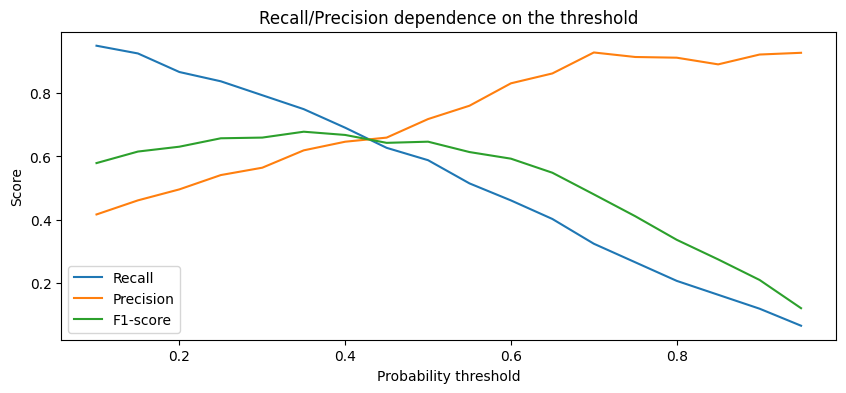

In [171]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = log_reg_poly.predict_proba(X_test_poly)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [172]:
# Найдем точки, где метрики пересекаются (или находятся близко друг к другу)
tolerance = 0.04  # Добавлаем толерантность для нахождения точек, которые приблизительно одинаковы
intersection_points = []

for i in range(len(thresholds)):
    if (abs(recall_scores[i] - precision_scores[i]) < tolerance and 
        abs(recall_scores[i] - f1_scores[i]) < tolerance and 
        abs(precision_scores[i] - f1_scores[i]) < tolerance):
        intersection_points.append((thresholds[i], recall_scores[i], precision_scores[i], f1_scores[i]))

# Находим точку пересечения с наивысшим F1-score
if intersection_points:
    best_point = max(intersection_points, key=lambda x: x[3])
    best_threshold = best_point[0]
    highest_f1 = best_point[3]
else:
    best_threshold = None
    highest_f1 = None

print(f"Точки пересечения метрик: {[round(point[0], 2) for point in intersection_points]}")
print(f"Самый высокий показатель F1 среди точек пересечения: {round(highest_f1, 2) if highest_f1 is not None else None}")
print(f"Значение порога вероятности в самой высокой точке пересечения: {round(best_threshold, 2) if best_threshold is not None else None}")

Точки пересечения метрик: [0.45]
Самый высокий показатель F1 среди точек пересечения: 0.64
Значение порога вероятности в самой высокой точке пересечения: 0.45


Попробуем выставить значение параметра порога вероятности на 0.4

In [173]:
# Используем этот порог для предсказания классов на тестовой выборке
best_threshold=0.4
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > best_threshold else 0)
# Считаем метрики на тестовой выборке
print("Метрики на тестовой выборке с оптимальным порогом (0.4):")
print(metrics.classification_report(y_test, y_test_pred_opt))

# Нас интересует только вероятность класса (второй столбец) на тренировочной выборке
y_train_proba_pred = log_reg_poly.predict_proba(X_train_poly)[:, 1]
# Для удобства завернем numpy-массив в pandas Series
y_train_proba_pred = pd.Series(y_train_proba_pred)
# Используем этот порог для предсказания классов на тренировочной выборке
y_train_pred_opt = y_train_proba_pred.apply(lambda x: 1 if x > best_threshold else 0)
# Считаем метрики на тренировочной выборке
print("Метрики на тренировочной выборке с оптимальным порогом (0.4):")
print(metrics.classification_report(y_train, y_train_pred_opt))

Метрики на тестовой выборке с оптимальным порогом (0.4):
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       424
           1       0.65      0.69      0.67       204

    accuracy                           0.78       628
   macro avg       0.75      0.75      0.75       628
weighted avg       0.78      0.78      0.78       628

Метрики на тренировочной выборке с оптимальным порогом (0.4):
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1271
           1       0.64      0.71      0.67       610

    accuracy                           0.78      1881
   macro avg       0.75      0.76      0.75      1881
weighted avg       0.78      0.78      0.78      1881



При пороге вероятности 0.4  значение метрики F-1 на тренировочной и тестовой выборках повышается до 0.67.

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


Хоть логарифмирование не так сильно влияет на деревья решений, как на модели регрессии, все же оно может помочь немоного путем сглаживания выбрособ. Так что возьмем за основу датасет с логарифмированными числовыми прознаками, где мы удалили три признака с мультиколлинераностью.

In [174]:
X = log_data_cleaned.drop("Exited", axis=1)
y = log_data_cleaned["Exited"]

In [175]:
#разделяем выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 15)
Test shape: (628, 15)


Импортируем необходимые для выполнения практики модули:

In [176]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [177]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_full = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий эффективности
    random_state=42 #генератор случайных чисел
)
#Обучаем модель по алгоритму CART
dt_clf_full.fit(X_train, y_train)

#Делаем предсказание класса
y_pred_train = dt_clf_full.predict(X_train)
#Выводим отчёт о метриках
print(metrics.classification_report(y_train, y_pred_train))

y_pred_test = dt_clf_full.predict(X_test)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1271
           1       1.00      1.00      1.00       610

    accuracy                           1.00      1881
   macro avg       1.00      1.00      1.00      1881
weighted avg       1.00      1.00      1.00      1881

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       424
           1       0.57      0.55      0.56       204

    accuracy                           0.72       628
   macro avg       0.68      0.68      0.68       628
weighted avg       0.72      0.72      0.72       628



Налицо перепбучение модели — 100% точность на тренировочной выборке и только 56% на тестовой (по метрике F1-мера). Так произошло, потому что мы не задали для модели никаких ограничений, такох как глубина дерева и размер выборки в листах. 

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [178]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_full = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий эффективности
    random_state=42, #генератор случайных чисел
    max_depth=8,
    min_samples_leaf=10
)
#Обучаем модель по алгоритму CART
dt_clf_full.fit(X_train, y_train)

#Делаем предсказание класса
y_pred_train = dt_clf_full.predict(X_train)
#Выводим отчёт о метриках
print(metrics.classification_report(y_train, y_pred_train))

#Делаем предсказание класса
y_pred_test = dt_clf_full.predict(X_test)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1271
           1       0.76      0.68      0.72       610

    accuracy                           0.82      1881
   macro avg       0.80      0.79      0.79      1881
weighted avg       0.82      0.82      0.82      1881

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       424
           1       0.71      0.57      0.63       204

    accuracy                           0.78       628
   macro avg       0.76      0.73      0.74       628
weighted avg       0.78      0.78      0.78       628



Переобучение значительно снижено, а целевая метрика на тестовой выборке выросла с 56 до 63 процентов. Все еще не очень хороший результат.

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [179]:
#Создаём объект класса случайный лес
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=8, #максимальная глубина дерева
    #max_features='sqrt', #число признаков из метода случайных подространств
    random_state=42, #генератор случайных чисел
    min_samples_leaf=10
)
#Обучаем модель 
rf_clf.fit(X, y)

#Делаем предсказание класса
y_pred_train = rf_clf.predict(X_train)
#Выводим отчёт о метриках
print(metrics.classification_report(y_train, y_pred_train))

#Делаем предсказание класса
y_pred_test = rf_clf.predict(X_test)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1271
           1       0.81      0.60      0.69       610

    accuracy                           0.83      1881
   macro avg       0.82      0.77      0.79      1881
weighted avg       0.82      0.83      0.82      1881

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       424
           1       0.78      0.61      0.68       204

    accuracy                           0.82       628
   macro avg       0.80      0.76      0.78       628
weighted avg       0.81      0.82      0.81       628



Целевая мерика на тестовой выборке повысилась до 68%, метрика ма целевой выборке очень близка (69%) — переобучение отсутствует, модель хорошо справляется с заданием предсказания оттока клиентов. 

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



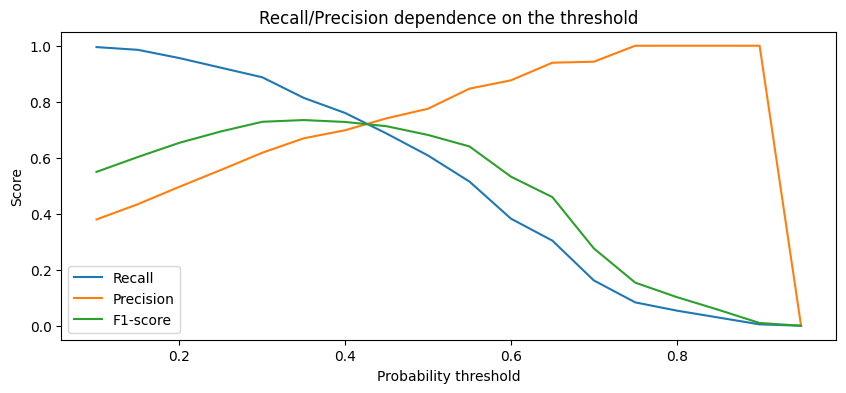

In [180]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = rf_clf.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

Как и с логистической регрессией, наиболее оптимальный порог вероятности = 0.4. Сделаем новые предсказания классов с таким порогом. 

In [183]:
# Используем этот порог для предсказания классов на тестовой выборке
best_threshold=0.4
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > best_threshold else 0)
# Считаем метрики на тестовой выборке
print("Метрики на тестовой выборке с оптимальным порогом (0.4):")
print(metrics.classification_report(y_test, y_test_pred_opt))

#Нас интересует только вероятность класса (второй столбец)
y_train_proba_pred = rf_clf.predict_proba(X_train)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_train_proba_pred = pd.Series(y_train_proba_pred)
# Используем этот порог для предсказания классов на тренировочной выборке
y_train_pred_opt = y_train_proba_pred.apply(lambda x: 1 if x > best_threshold else 0)
# Считаем метрики на тренировочной выборке
print("Метрики на тренировочной выборке с оптимальным порогом (0.4):")
print(metrics.classification_report(y_train, y_train_pred_opt))

Метрики на тестовой выборке с оптимальным порогом (0.4):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       424
           1       0.70      0.76      0.73       204

    accuracy                           0.82       628
   macro avg       0.79      0.80      0.79       628
weighted avg       0.82      0.82      0.82       628



Метрики на тренировочной выборке с оптимальным порогом (0.4):
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1271
           1       0.72      0.74      0.73       610

    accuracy                           0.82      1881
   macro avg       0.80      0.80      0.80      1881
weighted avg       0.82      0.82      0.82      1881



Финальное значение метрики F-1 у нашей модели для тестовых, как и для тренировочных, данных — 0.73. Наилучшей моделью оказался алгоритм Random Forest с порогом вероятносто 0.4 и следющими параметрами: 

    n_estimators=500, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=8, #максимальная глубина дерева
    random_state=42, #генератор случайных чисел
    min_samples_leaf=10 #размер выборки в листах

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [185]:
#Выведем информацию об исходной матрице значений
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2509 entries, 7 to 9998
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CreditScore          2509 non-null   float64
 1   Balance              2509 non-null   float64
 2   HasCrCard            2509 non-null   int64  
 3   IsActiveMember       2509 non-null   int64  
 4   BalanceSalaryRatio   2509 non-null   float64
 5   TenureByAge          2509 non-null   float64
 6   CreditScoreGivenAge  2509 non-null   float64
 7   Tenure_High          2509 non-null   int64  
 8   Tenure_Low           2509 non-null   int64  
 9   Tenure_Mid           2509 non-null   int64  
 10  Gender_Female        2509 non-null   int64  
 11  Gender_Male          2509 non-null   int64  
 12  NumOfProducts_2      2509 non-null   int64  
 13  NumOfProducts_3      2509 non-null   int64  
 14  NumOfProducts_4      2509 non-null   int64  
dtypes: float64(5), int64(10)
memory usage: 313.

In [186]:
X.head()

,CreditScore,Balance,HasCrCard,IsActiveMember,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Tenure_High,Tenure_Low,Tenure_Mid,Gender_Female,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
7,5.929589,11.653094,1,0,-0.036696,-1.981001,2.562293,0,0,1,1,0,0,0,1
15,6.423247,11.871504,0,1,0.799766,-2.708050,2.616584,0,0,1,0,1,1,0,0
16,6.481577,11.795114,1,0,3.258575,-4.060443,2.421134,0,1,0,0,1,0,0,0
26,6.628041,11.826390,1,1,-0.217411,-2.890372,3.044522,1,0,0,0,1,0,0,0
28,6.352629,11.858990,1,1,0.344192,-2.662588,2.591429,0,0,1,1,0,0,0,0


In [187]:
#Сохраним и преобразуем данные нового клиента

vasily_info = {
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}

#Напишем ф-ю, которая будет трансформировать новые данные в формат нашей матрицы данных
def transform_client_data(client_info):
    """
    Трансформирует данные клиента в формат, соответствующий тренировочным данным.

    Аргументы:
    client_info (dict): Словарь, содержащий информацию о клиенте.

    Возвращает:
    pd.DataFrame: Трансформированные данные клиента, готовые для предсказания.
    """
    # Преобразуем словарь в DataFrame
    client_df = pd.DataFrame(client_info)
    
    # Создаем дополнительные признаки
    client_df['BalanceSalaryRatio'] = client_df['Balance'] / client_df['EstimatedSalary']
    client_df['TenureByAge'] = client_df['Tenure'] / client_df['Age']
    client_df['CreditScoreGivenAge'] = client_df['CreditScore'] / client_df['Age']

    # Логарифмируем числовые признаки
    client_df['CreditScore'] = np.log(client_df['CreditScore'])
    client_df['Balance'] = np.log(client_df['Balance'])
    client_df['BalanceSalaryRatio'] = np.log(client_df['BalanceSalaryRatio'])
    client_df['TenureByAge'] = np.log(client_df['TenureByAge'])
    client_df['CreditScoreGivenAge'] = np.log(client_df['CreditScoreGivenAge'])
    
    # Кодируем категориальные переменные с помощью one-hot encoding
    client_df['Gender_Male'] = (client_df['Gender'] == 'Male').astype(int)
    client_df['Gender_Female'] = (client_df['Gender'] == 'Female').astype(int)
    client_df['NumOfProducts_2'] = (client_df['NumOfProducts'] == 2).astype(int)
    client_df['NumOfProducts_3'] = (client_df['NumOfProducts'] == 3).astype(int)
    client_df['NumOfProducts_4'] = (client_df['NumOfProducts'] == 4).astype(int)
    
    # Создаем признаки, связанные с tenure
    client_df['Tenure_High'] = (client_df['Tenure'] > 6).astype(int)
    client_df['Tenure_Low'] = (client_df['Tenure'] <= 3).astype(int)
    client_df['Tenure_Mid'] = ((client_df['Tenure'] > 3) & (client_df['Tenure'] <= 6)).astype(int)
    
    # Выбираем окончательные столбцы признаков в правильном порядке
    final_features = [
        'CreditScore', 'Balance', 'HasCrCard', 'IsActiveMember', 'BalanceSalaryRatio',
        'TenureByAge', 'CreditScoreGivenAge', 'Tenure_High', 'Tenure_Low', 'Tenure_Mid',
        'Gender_Female', 'Gender_Male', 'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4'
    ]
    
    # Убеждаемся, что все окончательные признаки присутствуют в DataFrame
    for feature in final_features:
        if feature not in client_df.columns:
            client_df[feature] = 0
    
    return client_df[final_features]


# Трансформируем данные Василия
vasily_transformed = transform_client_data(vasily_info)
vasily_transformed

,CreditScore,Balance,HasCrCard,IsActiveMember,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Tenure_High,Tenure_Low,Tenure_Mid,Gender_Female,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,6.398595,11.497768,1.0,0.0,0.900765,-3.73767,2.660925,0,1,0,0,1,0,0,0


In [188]:

# Предсказываем вероятности
proba = rf_clf.predict_proba(vasily_transformed)[:, 1]

# Применяем порог для получения окончательного предсказания
threshold = 0.4
prediction = (proba > threshold).astype(int)

print(f"Вероятность класса 1: {proba[0]}")
print(f"Предсказание (1, если вероятность > {threshold}, иначе 0): {prediction[0]}")

Вероятность класса 1: 0.6844718434644205
Предсказание (1, если вероятность > 0.4, иначе 0): 1


Итак, по оценке нашей модели Василий принадлежит к Классу 1 (уйдет в ближайшее время) с вероятностью 0.68.